In [275]:
import re
import pickle
import string
import gensim
import pandas            as pd
import matplotlib.pyplot as plt

from nltk                            import word_tokenize
from nltk.corpus                     import stopwords
from nltk.tokenize                   import TweetTokenizer
from nltk.stem.porter                import PorterStemmer
from wordcloud                       import WordCloud
from collections                     import Counter
from gensim.models                   import Word2Vec
from sklearn.manifold                import TSNE
from IPython.core.display            import HTML
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn                         import svm
from sklearn.metrics                 import f1_score
from sklearn.neighbors               import KNeighborsClassifier

In [276]:
location = './twitter_data/train2017.tsv'
df = pd.read_csv(location , sep = "\t" , header = None)

In [277]:
# ndf = df.head(10) #takes the first x entries

# dl = ndf.values.tolist()

dl = df.values.tolist()

emotions    = []
positives   = []
negatives   = []
neutrals    = []
tokens      = []
fusedTokens = []
tknzr       = TweetTokenizer(preserve_case = False, 
                             strip_handles = True, 
                             reduce_len    = True)
for item in dl:
#     print("\nITEM = ",item)
    tweet = item[3]
    emotions.append(item[2])
#     if item[2] == "positive":
#         emotions.append(1)
#     elif item[2] == "negative":
#         emotions.append(-1)
#     elif item[2] == "neutral":
#         emotions.append(0)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*' , '' , tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+' , '' , tweet)
 
    # remove hyperlinks
#     tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    
    # remove hashtags, removing the hash (#) sign only from the word
    tweet = re.sub(r'#' , '' , tweet)
    
    temp = tknzr.tokenize(tweet)
    
#     print("TEMP 1 = ",temp)
    
#     temp = [w.lower() for w in temp] #convert to lower case
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "it's" , "we're" , "you're" , "they're" , "via"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words
#     print("TEMP 2 = ",temp)

    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
#     print("TEMP 3 = ",temp)

    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic
#     print("TEMP 4 = ",temp)

#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    if item[2] == "positive":  #need to give the words positive and negative weight so that the most common words in positive posts is not "tomorrow"
        positives.extend(temp)
    elif item[2] == "negative":
        negatives.extend(temp)
    elif item[2] == "neutral":
        neutrals.extend(temp)
        
    fusedTokens.extend(temp)
    tokens.append(temp)
    
# print("\n\033[1;33mPrinting Tokens\033[0m")
# for i,tok in enumerate(tokens):
#     print("\033[1;34m->\033[0m",tok)
# print("\n\033[1;33mPrinting Fuzed Tokens\033[0m")
# print(fusedTokens)

In [278]:
count = Counter(fusedTokens)
print("\033[1;33mGenerally most common words:\033[0m\n" , count.most_common(10))

count = Counter(positives)
print("\033[1;33m\nMost common words found in positive posts:\033[0m\n" , count.most_common(10))

count = Counter(negatives)
print("\033[1;33m\nMost common words found in negative posts:\033[0m\n" , count.most_common(10))

count = Counter(neutrals)
print("\033[1;33m\nMost common words found in neutral posts:\033[0m\n" , count.most_common(10))

Generally most common words:
 [('tomorrow', 4449), ('may', 3000), ('day', 2273), ('going', 2090), ('night', 1796), ('see', 1660), ('u', 1560), ('time', 1559), ('go', 1512), ('friday', 1479)]

Most common words found in positive posts:
 [('tomorrow', 2112), ('may', 1189), ('day', 1180), ('see', 928), ('night', 878), ('good', 856), ('going', 824), ('friday', 687), ('time', 661), ('love', 640)]

Most common words found in negative posts:
 [('may', 653), ('tomorrow', 630), ('like', 342), ('going', 318), ('u', 295), ('day', 290), ('go', 266), ('time', 250), ('get', 246), ('night', 202)]

Most common words found in neutral posts:
 [('tomorrow', 1707), ('may', 1158), ('going', 948), ('u', 814), ('day', 803), ('night', 716), ('go', 682), ('saturday', 659), ('time', 648), ('friday', 645)]


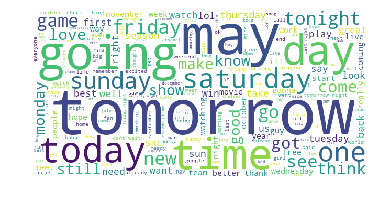

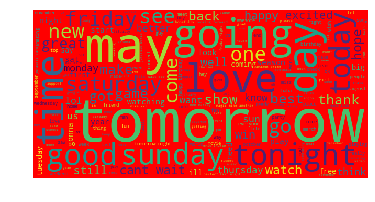

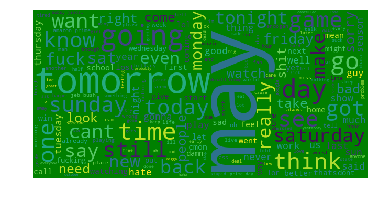

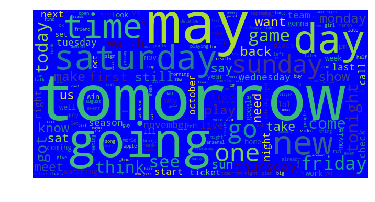

In [279]:
final = ""
for word in fusedTokens:
    final += " " + word
    
wc = WordCloud(background_color = "white", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in positives:
    final += " " + word
    
wc = WordCloud(background_color = "red", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in negatives:
    final += " " + word
    
wc = WordCloud(background_color = "green", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in neutrals:
    final += " " + word
    
wc = WordCloud(background_color = "blue", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

Generally we can see that words like "love" appear in positive posts as expected , whereas "positive" words like "like" appear in negative posts . Also there are many neutral words like "tomorrow" that have the same distribution in both positive and negative posts.

In [280]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
#     print(final)
    newTokens.append(final)
    
# bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=100, stop_words='english')
bow_vectorizer = CountVectorizer(max_features=100) 
bow_xtrain = bow_vectorizer.fit_transform(newTokens)  #TWEETS : a list with the actual tweets 
# print(bow_vectorizer.get_feature_names())
# print(bow_xtrain.toarray())

# The output is a numpy array of features. The dimensionality of this array 
# depends on the number of TWEETS (shape should be number_of_tweets ∙ vocabulary_size) 
print(bow_xtrain.shape)

# filename = "bow.pkl"
outfile = open("bigbow.pkl" , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

(27958, 100)


In [281]:
# print(bow_vectorizer.get_feature_names())

# for box in bow_xtrain.toarray():
#     print(box)

In [282]:
# tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english') 
tfidf_vectorizer = TfidfVectorizer(max_features=100) 
tfidf = tfidf_vectorizer.fit_transform(newTokens)
print(tfidf.shape) #the output is a numpy array of features


# filename = "tfidf.pkl"
outfile = open("bigtfidf.pkl" , "wb")
pickle.dump(tfidf , outfile)
outfile.close()

(27958, 100)


In [283]:
# tokenized_tweet = tweets.apply(lambda x: x.split()) # tokenizing 

featuresSize = 200

model_w2v = gensim.models.Word2Vec(tokens,
                                   size      = featuresSize, # desired no. of features/independent variables
                                   window    = 5,  # context window size
                                   min_count = 2,
                                   sg        = 1,  # 1 for skip-gram model
                                   hs        = 0,
                                   negative  = 10, # for negative sampling
                                   workers   = 2,  # no.of cores
                                   seed      = 34) 

model_w2v.train(tokens, total_examples = len(tokens), epochs = 20)


(5218401, 5888380)

In [284]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model.wv.__getitem__(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity = 40, n_components = 2, init = 'pca', n_iter = 2500, random_state = 23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize = (16,16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy = (x[i], y[i]), xytext = (5,2), textcoords = 'offset points', ha = 'right', va = 'bottom')
        
    plt.show()

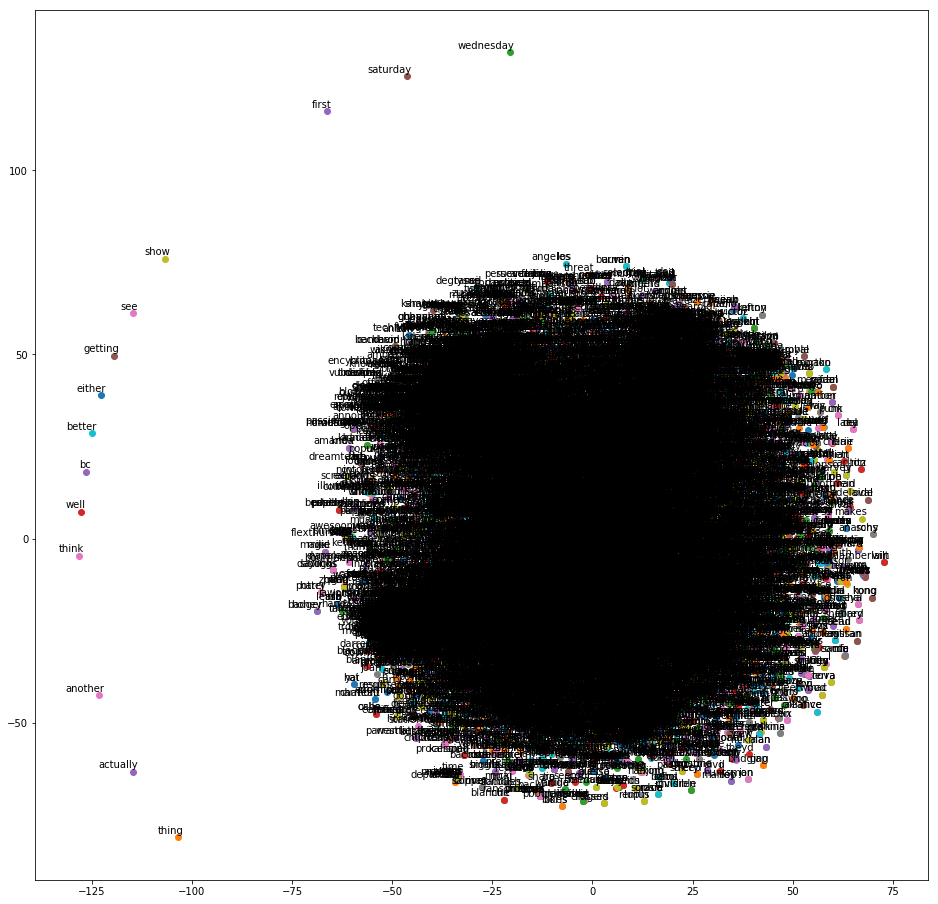

In [285]:
tsne_plot(model_w2v)

In [286]:
dictNum  = 1
allDicts = []

dictLocation = "./lexica/generic/generic.txt"
file = open(dictLocation, "r")
genericDict = []
for line in file:
    temp  = []
    count = 1
    for word in line.split():
        if count == 1:
            temp.append(word)
        else:
            temp.append(float(word))
        count += 1
    genericDict.extend([temp])
    
allDicts.extend([genericDict])

In [287]:
# dictNum += 1

# dictLocation = "./lexica/emotweet/valence_tweet.txt"
# file = open(dictLocation, "r")
# dic = []
# for line in file:
#     temp = []
#     count = 1
#     for word in line.split():
#         if count == 1:
#             temp.append(word)
#         else:
#             temp.append(float(word))
#         count += 1
#     dic.extend([temp])
    
# allDicts.extend([dic])

In [288]:
word_vectors = model_w2v.wv
allTweetFeatsList = []

for sentence in tokens:
    
    tweetFeatures = []
    
    for i in range(0,featuresSize):
        value     = 0
        wordCount = 0
        
        for word in sentence:
            if word in word_vectors.vocab:
                wordCount += 1
                value     += word_vectors[word][i]
                
        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)
    
    for dic in allDicts:
        wordCount = 0
        value     = 0

        for word in sentence:
            for token in dic:
                if word == token[0]:
                    wordCount += 1
                    value     += token[1]

        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)

#         print(tweetFeatures , "\n")
    
            
    allTweetFeatsList.extend([tweetFeatures])

# print(allTweetFeatsList)

# filename = "wordEmbs.pkl"
outfile = open("bigwordEmbs.pkl" , "wb")
pickle.dump(allTweetFeatsList , outfile)
outfile.close()

In [289]:
infile = open("bigbow.pkl" , "rb")
bow_xtrain = pickle.load(infile)
infile.close()
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_xtrain, emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [290]:

svcBow = svm.SVC(kernel='linear', C=1, probability=True)
svcBow = svcBow.fit(xtrain_bow, ytrain) # xtrain_bow:bag of words features for train data, ytrain: train data labels

# probPrediction = svcBow.predict_proba(xvalid_bow) #predict on the validation set
prediction_int = svcBow.predict(xvalid_bow)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set



0.555793991416309

In [291]:
outfile = open("predbow.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [292]:
infile = open("bigtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

xtrain, xvalid, ytrain, yvalid = train_test_split(tfidf , emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [293]:
svcIdf = svm.SVC(kernel='linear', C=1, probability=True)
svcIdf = svcIdf.fit(xtrain, ytrain) # xtrain:tfidf features for train data, ytrain: train data labels

# probPrediction = svcIdf.predict_proba(xvalid) #predict on the validation set
prediction_int = svcIdf.predict(xvalid)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set

0.5502503576537912

In [294]:
outfile = open("predtfidf.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [295]:
infile = open("bigwordEmbs.pkl" , "rb")
allTweetFeatsList = pickle.load(infile)
infile.close()

xtrain, xvalid, ytrain, yvalid = train_test_split(allTweetFeatsList , emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [296]:
svcW2V = svm.SVC(kernel='linear', C=1, probability=True)
svcW2V = svcW2V.fit(xtrain, ytrain) # xtrain:word2vec features for train data, ytrain: train data labels

# probPrediction = svcW2V.predict_proba(xvalid) #predict on the validation set
prediction_int = svcW2V.predict(xvalid)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set

0.6208869814020028

In [297]:
outfile = open("predwordEmbs.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

Doing the same with test data :

In [298]:
location = './twitter_data/test2017.tsv'
df = pd.read_csv(location , sep = "\t" , header = None)
emoLocation = './twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
emoFile = open(emoLocation, "r")
testEmotions = []
for line in emoFile:
    temp  = []
    count = 1
    for word in line.split():
        if count == 2:
            temp.append(word)
        count += 1
    testEmotions.extend(temp)
    


In [299]:
# ndf = df.head(1000) #takes the first x entries

# dl = ndf.values.tolist()

dl = df.values.tolist()

tokens      = []
fusedTokens = []
tknzr       = TweetTokenizer(preserve_case = False, 
                             strip_handles = True, 
                             reduce_len    = True)
for item in dl:
    tweet = item[3]
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*' , '' , tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+' , '' , tweet)
 
    # remove hyperlinks
    tweet = re.sub(r"http\S+", "", tweet)
    
    # remove hashtags, removing the hash (#) sign only from the word
    tweet = re.sub(r'#' , '' , tweet)
    
    temp = tknzr.tokenize(tweet)
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "it's" , "we're" , "you're" , "they're" , "via"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words

    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
#     print("TEMP 3 = ",temp)
    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic

#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    
    fusedTokens.extend(temp)
    tokens.append(temp)
    

In [300]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
    newTokens.append(final)
    
bow_xtest = bow_vectorizer.transform(newTokens)  #TWEETS : a list with the actual tweets 

# The output is a numpy array of features. The dimensionality of this array 
# depends on the number of TWEETS (shape should be number_of_tweets ∙ vocabulary_size) 
print(bow_xtest.shape)

outfile = open("testbow.pkl" , "wb")
pickle.dump(bow_xtest , outfile)
outfile.close()

(12284, 100)


In [301]:
tfidf = tfidf_vectorizer.transform(newTokens)
print(tfidf.shape) #the output is a numpy array of features


outfile = open("testtfidf.pkl" , "wb")
pickle.dump(tfidf , outfile)
outfile.close()

(12284, 100)


In [302]:
featuresSize = 200

model_w2v = gensim.models.Word2Vec(tokens,
                                   size      = featuresSize, # desired no. of features/independent variables
                                   window    = 5,  # context window size
                                   min_count = 2,
                                   sg        = 1,  # 1 for skip-gram model
                                   hs        = 0,
                                   negative  = 10, # for negative sampling
                                   workers   = 2,  # no.of cores
                                   seed      = 34) 

model_w2v.train(tokens, total_examples = len(tokens), epochs = 20)

(1901629, 2151820)

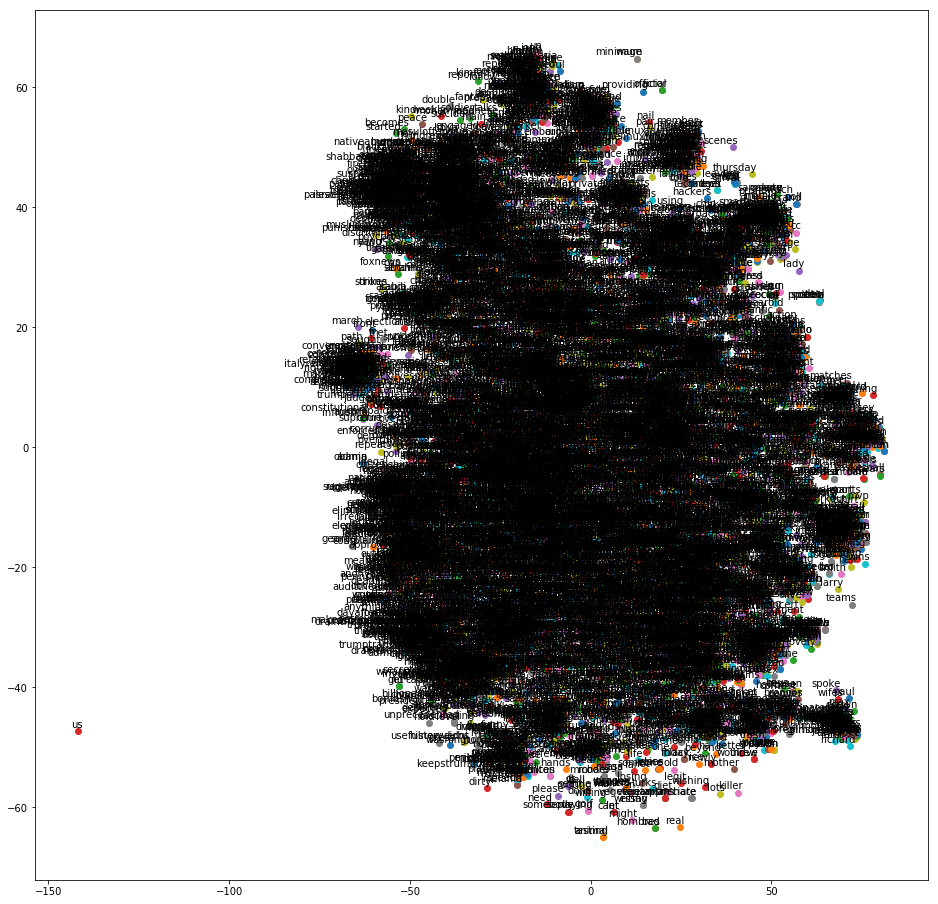

In [303]:
tsne_plot(model_w2v)

In [304]:
word_vectors = model_w2v.wv
allTweetFeatsList = []

for sentence in tokens:
    
    tweetFeatures = []
    
    for i in range(0,featuresSize):
        value     = 0
        wordCount = 0
        
        for word in sentence:
            if word in word_vectors.vocab:
                wordCount += 1
                value     += word_vectors[word][i]
                
        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)
    
    for dic in allDicts:
        wordCount = 0
        value     = 0

        for word in sentence:
            for token in dic:
                if word == token[0]:
                    wordCount += 1
                    value     += token[1]

        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)

    allTweetFeatsList.extend([tweetFeatures])

# filename = "wordEmbs.pkl"
outfile = open("testwordEmbs.pkl" , "wb")
pickle.dump(allTweetFeatsList , outfile)
outfile.close()

In [305]:
infile = open("testbow.pkl" , "rb")
bow_xtest = pickle.load(infile)
infile.close()


In [306]:
# probPrediction = svcBow.predict_proba(bow_xtrain) #predict on the validation set
prediction_int = svcBow.predict(bow_xtest)
prediction_int = prediction_int.tolist()
f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

0.5029306414848583

In [307]:
outfile = open("predtestbow.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [308]:
infile = open("testtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

In [309]:
# probPrediction = svcIdf.predict_proba(tfidf) #predict on the validation set
prediction_int = svcIdf.predict(tfidf)
prediction_int = prediction_int.tolist()

f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

0.49918593292087265

In [310]:
outfile = open("predtesttfidf.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [311]:
infile = open("testwordEmbs.pkl" , "rb")
allTweetFeatsList = pickle.load(infile)
infile.close()

In [312]:
# probPrediction = svcW2V.predict_proba(allTweetFeatsList) #predict on the validation set
prediction_int = svcW2V.predict(allTweetFeatsList)
prediction_int = prediction_int.tolist()

f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

0.43218821230869425

In [313]:
outfile = open("predtestwordEmbs.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [314]:
infile = open("bigbow.pkl" , "rb")
bow_xtrain = pickle.load(infile)
infile.close()

In [315]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(bow_xtrain , emotions)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [316]:
infile = open("testbow.pkl" , "rb")
bow_xtest = pickle.load(infile)
infile.close()

In [317]:
prediction_knn = knn.predict(bow_xtest)
f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

0.2963204168023445

In [318]:
infile = open("bigtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

In [319]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(tfidf , emotions)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [320]:
infile = open("testtfidf.pkl" , "rb")
tfidf_new = pickle.load(infile)
infile.close()

In [321]:
prediction_knn = knn.predict(tfidf_new)
f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

0.48086942364050794

In [322]:
infile = open("bigwordEmbs.pkl" , "rb")
w2v = pickle.load(infile)
infile.close()

In [323]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(w2v , emotions)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [324]:
infile = open("testwordEmbs.pkl" , "rb")
w2v_new = pickle.load(infile)
infile.close()

In [325]:
prediction_knn = knn.predict(w2v_new)
f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

0.48078801693259526